## 3.Language Model Using RNN (Text Generation)

**Content:**
1. Load Truyện Kiều dataset
    - Load dataset
    - preprocess: removal punctuation, lowercasing,...
    - Build data: input and output

    Example: "Trăm năm trong cõi người ta"
        - Input: trăm => Output: năm
        - ...
        - Input: trăm năm trong cõi người => Output: ta
2. Representation:
    - Word-based Tokenization
    - Build Vocabulary
    - Padding or Truncating sequences
3. Define Text Classification Model (Basic Model):
    - 1 Embedding layer
    - 1 SimpleRNN layer
    - 1 Dense layer
    - 1 Dense layer => Output: probability of words in vocabulary
    - Loss: Categorical Crossentropy
4. Predict test sentence:
    - Given one or more word => predict some next words

    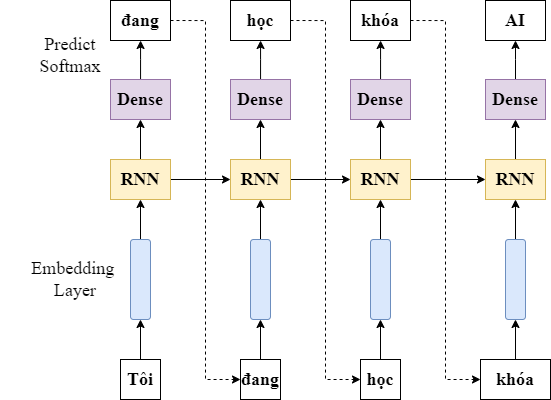

### 3.1.Load Truyện Kiều Dataset

In [35]:
!gdown --id 1Cm5iZJwcC-rrnUpSP1LWj2LMpytaT3gj

Downloading...
From: https://drive.google.com/uc?id=1Cm5iZJwcC-rrnUpSP1LWj2LMpytaT3gj
To: /content/truyen_kieu.txt
100% 140k/140k [00:00<00:00, 43.4MB/s]


In [36]:
corpus = []
with open("/content/truyen_kieu.txt", "r") as f:
    corpus = f.readlines()

In [37]:
corpus[:5]

['1..Trăm năm trong cõi người ta,\n',
 '2..Chữ tài chữ mệnh khéo là ghét nhau.\n',
 '3..Trải qua một cuộc bể dâu,\n',
 '4..Những điều trông thấy mà đau đớn lòng.\n',
 '5.. Lạ gì bỉ sắc tư phong,\n']

#### Preprocessing
Removal punctuation, lowercasing,...

In [38]:
import string
import pandas as pd
PUNCT_TO_REMOVE = string.punctuation + string.digits + "\n"
def clean_text(text):
    """custom function to removal: punctuations and digits"""
    text = text.translate(str.maketrans(' ', ' ', PUNCT_TO_REMOVE))
    text = text.lower()
    return text
clean_text(corpus[0])

'trăm năm trong cõi người ta'

In [39]:
corpus = [clean_text(line) for line in corpus]
corpus[:5]

['trăm năm trong cõi người ta',
 'chữ tài chữ mệnh khéo là ghét nhau',
 'trải qua một cuộc bể dâu',
 'những điều trông thấy mà đau đớn lòng',
 ' lạ gì bỉ sắc tư phong']

#### Build Data

In [40]:
train_sentences = []
train_labels = []
for line in corpus:
    list_words = line.split()
    for i in range(1, len(list_words)):
        sentence = list_words[:i]
        label = list_words[i]

        train_sentences.append(sentence)
        train_labels.append(label)

In [41]:
for i in range(5):
    print('Input data: {} => output data: {}'.format(train_sentences[i], train_labels[i]))

Input data: ['trăm'] => output data: năm
Input data: ['trăm', 'năm'] => output data: trong
Input data: ['trăm', 'năm', 'trong'] => output data: cõi
Input data: ['trăm', 'năm', 'trong', 'cõi'] => output data: người
Input data: ['trăm', 'năm', 'trong', 'cõi', 'người'] => output data: ta


### 3.2.Representation

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku

In [44]:
vocab_size = 5000
max_len = 7

In [45]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)

In [46]:
num_words = len(tokenizer.word_index) + 1

In [47]:
# convert text to features
train_sequences = tokenizer.texts_to_sequences(train_sentences)

# padding or truncating
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_len, 
                                       truncating='pre', padding="pre")

In [48]:
train_padded_sequences

array([[  0,   0,   0, ...,   0,   0, 143],
       [  0,   0,   0, ...,   0, 143,  77],
       [  0,   0,   0, ..., 143,  77,  27],
       ...,
       [  0,   0, 795, ...,   9,  89,   2],
       [  0, 795, 241, ...,  89,   2, 332],
       [795, 241,   9, ...,   2, 332, 756]], dtype=int32)

In [49]:
# one-hot
train_labels = tokenizer.texts_to_sequences(train_labels)
train_labels = ku.to_categorical(train_labels, num_classes=num_words)

In [50]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 3.3.Define Language Model (Basic Model)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [82]:
generator_model = Sequential()
generator_model.add(Embedding(num_words, 
                              embedding_dim, 
                              input_length=max_len))
generator_model.add(SimpleRNN(hidden_size))
generator_model.add(Dense(num_words/2, activation='relu'))
generator_model.add(Dense(num_words, activation='softmax'))

In [83]:
generator_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 7, 300)            723600    
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 256)               142592    
                                                                 
 dense_8 (Dense)             (None, 1206)              309942    
                                                                 
 dense_9 (Dense)             (None, 2412)              2911284   
                                                                 
Total params: 4,087,418
Trainable params: 4,087,418
Non-trainable params: 0
_________________________________________________________________


In [84]:
generator_model.compile(loss='categorical_crossentropy', 
                        optimizer='adam', 
                        metrics=['acc'])
generator_history = generator_model.fit(train_padded_sequences, 
                                        train_labels, 
                                        epochs=20)

Epoch 1/20
611/611 [==============================] - 7s 9ms/step - loss: 6.9204 - acc: 0.0199
Epoch 2/20
611/611 [==============================] - 6s 10ms/step - loss: 6.2705 - acc: 0.0418
Epoch 3/20
611/611 [==============================] - 6s 10ms/step - loss: 5.6100 - acc: 0.0823
Epoch 4/20
611/611 [==============================] - 6s 10ms/step - loss: 4.7263 - acc: 0.1514
Epoch 5/20
611/611 [==============================] - 6s 10ms/step - loss: 3.5694 - acc: 0.2725
Epoch 6/20
611/611 [==============================] - 6s 10ms/step - loss: 2.3392 - acc: 0.4672
Epoch 7/20
611/611 [==============================] - 6s 10ms/step - loss: 1.4390 - acc: 0.6524
Epoch 8/20
611/611 [==============================] - 6s 10ms/step - loss: 1.0105 - acc: 0.7490
Epoch 9/20
611/611 [==============================] - 6s 10ms/step - loss: 0.8150 - acc: 0.7973
Epoch 10/20
611/611 [==============================] - 6s 10ms/step - loss: 0.7510 - acc: 0.8062
Epoch 11/20
611/611 [===================

### 3.4.Generate Text

In [85]:
def generate_text(input_words, next_words, generator_model):
    for i in range(next_words):
        sequence = tokenizer.texts_to_sequences([input_words])[0]
        test_padded_seqence = pad_sequences([sequence], 
                                            maxlen=max_len, 
                                            padding='pre')
        
        predict_word = generator_model.predict(test_padded_seqence)
        predict_max_word = np.argmax(predict_word, axis=1)
        
        # get word from index
        for word, index in tokenizer.word_index.items():
            if predict_max_word == index:
                output = word
                break
                
        input_words = input_words + " " + word
    return input_words

In [86]:
generate_text("thúy kiều", 4, generator_model)

'thúy kiều sắc sảo khôn ngoan'

In [90]:
generate_text("kim trọng và thúy kiều", 6, generator_model)

'kim trọng và thúy kiều nhân gian sao tan tành ngay'